The goal of this notebook is to plot the compilation times vs run times of Aquinas circuits.
We expect the run times will eventually surpass compilation times and explode.

In [1]:
# import AMDG
import numpy as np
import interferometer as itf
from matplotlib import pyplot as plt
from Aquinas.numeric_truncated_unitaries import *
from Aquinas.direct_decomposition import *
from Aquinas.boson_sampling_probabilities import *
from Aquinas.simulation import *
# from qiskit.quantum_info import Operator
import time

In [2]:
# A clone of run_interferom_simulation only this method returns:
#   + The time it takes to compile an interferometer
#   + The time it takes to run the interferometer for num_shots (default = 1)
def timed_interferom_simulation(U, photon_config, num_shots=1):
    """
    Compile and run a quantum circuit corresponding to a linear interferometer with unitary U.

    U: Unitary matrix
    photon_config: The initial configuration (distribution) of photons.
        i.e. [5,7] means 5 photons in mode 0, 7 photon in mode 1.
    num_shots: The number of times the circuit is simulated
    """
    num_photons = sum(photon_config)
    num_modes = int(np.shape(U)[0])
    qubits_per_mode = int(np.ceil(np.log2(num_photons + 1)))
    num_qubits = qubits_per_mode * num_modes
    circuit = QuantumCircuit(num_qubits)
    
    initial_state = dist_to_state(photon_config)[::-1] # Reversed for qiskit's little endian
    circuit.initialize(initial_state)
    #### Subroutine 1: compile quantum circuit from interferometer unitary
    start_compile_time = time.time()
    interferom = direct_decomposition(U, num_photons)
    circuit.compose(interferom, qubits=list(range(num_qubits)), inplace=True)
    circuit.measure_all()
    compile_time = time.time() - start_compile_time
    #### End subroutine 1:

    # print(f"Num qubits {circuit.num_qubits}")
    # print(f"Circuit depth = {circuit.depth()}")

    simulator = AerSimulator()
    circuit = transpile(circuit, simulator)
    #### Subroutine 2: run the quantum circuit for num_shots many times
    start_run_time = time.time()
    result = simulator.run(circuit, shots=num_shots).result()
    run_time = time.time() - start_run_time
    #### End subroutine 2
    counts = result.get_counts(circuit)

    # Convert counts to probabilities
    probs = dict()
    for key in counts.keys():
        # key is flipped since we no longer need to represent state in little endian
        output_dist = tuple(state_to_dist(key[::-1], num_modes = num_modes))
        probs[str(output_dist)] = counts[key] / num_shots

    print("         Compile time: ", compile_time, "s")
    print("         Run time: ", run_time, "s")

    return compile_time, run_time

In [3]:
"""
timed_interferom_simulation requires an initial photon configuration in order to
set the initial state of the circuit. I don't think it matters which state we choose.
This function takes a number of photons and a number of modes $m$ and returns
a photon config where all the photons are in the topmost mode
"""
def make_photon_config(num_photons, num_modes):
    photon_config = [0]*num_modes
    photon_config[0] = num_photons
    return photon_config

In [18]:
modes = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
photons = [1]
calc_times_1 = [[] for m in modes]

for idx, m in enumerate(modes):
    print(f"Running m = {m}")
    for n in photons:
        print(f"    Running n = {n}")
        U = random_unitary(m)
        photon_config = make_photon_config(num_photons=n, num_modes=m)
        compile_time, run_time = timed_interferom_simulation(U, photon_config)
        calc_times_1[idx].append((compile_time, run_time))

print("\n",calc_times_1)

Running m = 2
    Running n = 1
         Compile time:  0.011251449584960938 s
         Run time:  0.0018696784973144531 s
Running m = 3
    Running n = 1
         Compile time:  0.022770404815673828 s
         Run time:  0.0016183853149414062 s
Running m = 4
    Running n = 1
         Compile time:  0.03946232795715332 s
         Run time:  0.002115488052368164 s
Running m = 5
    Running n = 1
         Compile time:  0.0612483024597168 s
         Run time:  0.002721071243286133 s
Running m = 6
    Running n = 1
         Compile time:  0.09426617622375488 s
         Run time:  0.003347635269165039 s
Running m = 7
    Running n = 1
         Compile time:  0.12577605247497559 s
         Run time:  0.005838871002197266 s
Running m = 8
    Running n = 1
         Compile time:  0.17519688606262207 s
         Run time:  0.004810810089111328 s
Running m = 9
    Running n = 1
         Compile time:  0.2180335521697998 s
         Run time:  0.006837129592895508 s
Running m = 10
    Running n =

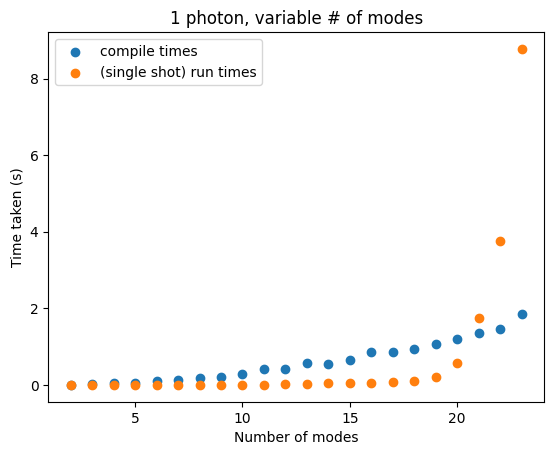

In [22]:
compile_times = [t[0][0] for t in calc_times_1]
run_times = [t[0][1] for t in calc_times_1]

plt.title("1 photon, variable # of modes")
plt.scatter(modes, compile_times, label=f"compile times")
plt.scatter(modes, run_times, label=f"(single shot) run times")
plt.legend()
plt.xlabel("Number of modes")
plt.ylabel("Time taken (s)")
plt.show()

In [6]:
modes = [2,3,4,5,6,7,8,9,10,11,12,13]
photons = [2]
calc_times = [[] for m in modes]

for idx, m in enumerate(modes):
    print(f"Running m = {m}")
    for n in photons:
        print(f"    Running n = {n}")
        U = random_unitary(m)
        photon_config = make_photon_config(num_photons=n, num_modes=m)
        compile_time, run_time = timed_interferom_simulation(U, photon_config)
        calc_times[idx].append((compile_time, run_time))

print("\n",calc_times)

Running m = 2
    Running n = 2
         Compile time:  0.2549557685852051 s
         Run time:  0.010004997253417969 s
Running m = 3
    Running n = 2
         Compile time:  0.45264625549316406 s
         Run time:  0.011845827102661133 s
Running m = 4
    Running n = 2
         Compile time:  1.128735065460205 s
         Run time:  0.022917509078979492 s
Running m = 5
    Running n = 2
         Compile time:  1.7135496139526367 s
         Run time:  0.04191899299621582 s
Running m = 6
    Running n = 2
         Compile time:  2.458778142929077 s
         Run time:  0.09796619415283203 s
Running m = 7
    Running n = 2
         Compile time:  3.5604970455169678 s
         Run time:  0.3066985607147217 s
Running m = 8
    Running n = 2
         Compile time:  4.737175703048706 s
         Run time:  0.36701416969299316 s
Running m = 9
    Running n = 2
         Compile time:  6.3840813636779785 s
         Run time:  0.36097288131713867 s
Running m = 10
    Running n = 2
         Compil

In [28]:
modes = [2,3,4,5,6,7,8,9,10,11,12,13]
calc_times_2 = [[(0.2549557685852051, 0.010004997253417969)], [(0.45264625549316406, 0.011845827102661133)], [(1.128735065460205, 0.022917509078979492)], [(1.7135496139526367, 0.04191899299621582)], [(2.458778142929077, 0.09796619415283203)], [(3.5604970455169678, 0.3066985607147217)], [(4.737175703048706, 0.36701416969299316)], [(6.3840813636779785, 0.36097288131713867)], [(7.608623266220093, 0.6725108623504639)], [(9.137235403060913, 2.6011455059051514)], [(11.23849081993103, 11.455031394958496)], [(13.142847061157227, 50.544822454452515)]]

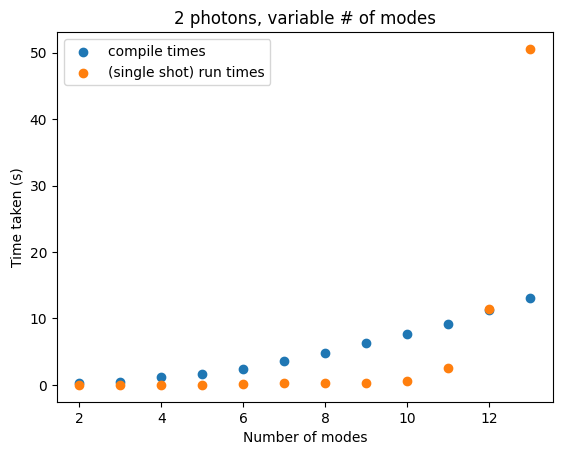

In [32]:
compile_times = [t[0][0] for t in calc_times_2]
run_times = [t[0][1] for t in calc_times_2]

plt.title("2 photons, variable # of modes")
plt.scatter(modes, compile_times, label=f"compile times")
plt.scatter(modes, run_times, label=f"(single shot) run times")
plt.legend()
plt.xlabel("Number of modes")
plt.ylabel("Time taken (s)")
plt.show()

In [10]:
modes = [2,3,4,5,6,7,8]
photons = [4]
calc_times = [[] for m in modes]

for idx, m in enumerate(modes):
    print(f"Running m = {m}")
    for n in photons:
        print(f"    Running n = {n}")
        U = random_unitary(m)
        photon_config = make_photon_config(num_photons=n, num_modes=m)
        compile_time, run_time = timed_interferom_simulation(U, photon_config)
        calc_times[idx].append((compile_time, run_time))

print("\n",calc_times)

Running m = 2
    Running n = 4
         Compile time:  2.911449909210205 s
         Run time:  0.06673669815063477 s
Running m = 3
    Running n = 4
         Compile time:  8.744642972946167 s
         Run time:  0.22429108619689941 s
Running m = 4
    Running n = 4
         Compile time:  17.599059343338013 s
         Run time:  0.7079203128814697 s
Running m = 5
    Running n = 4
         Compile time:  29.970601797103882 s
         Run time:  1.1470534801483154 s
Running m = 6
    Running n = 4
         Compile time:  44.16443920135498 s
         Run time:  2.5487444400787354 s
Running m = 7
    Running n = 4
         Compile time:  64.24372482299805 s
         Run time:  9.560981035232544 s
Running m = 8
    Running n = 4
         Compile time:  85.02300262451172 s
         Run time:  69.71501040458679 s

 [[(2.911449909210205, 0.06673669815063477)], [(8.744642972946167, 0.22429108619689941)], [(17.599059343338013, 0.7079203128814697)], [(29.970601797103882, 1.1470534801483154)], 

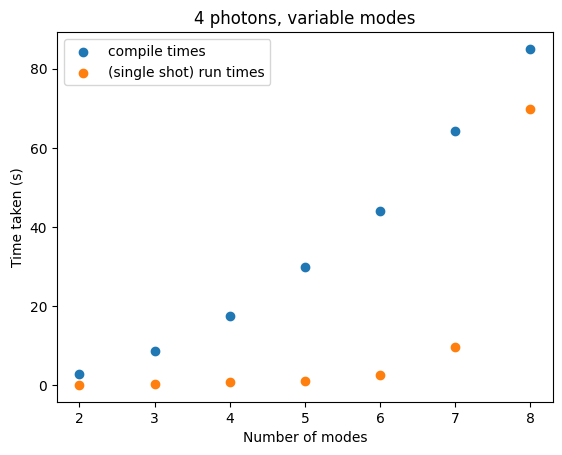

In [11]:
compile_times = [t[0][0] for t in calc_times]
run_times = [t[0][1] for t in calc_times]

plt.title("4 photons, variable modes")
plt.scatter(modes, compile_times, label=f"compile times")
plt.scatter(modes, run_times, label=f"(single shot) run times")
plt.legend()
plt.xlabel("Number of modes")
plt.ylabel("Time taken (s)")
# plt.yscale("log")
plt.show()

In [12]:
# Time elapsed: 25 minutes
modes = [2,3,4,5]
photons = [8]
calc_times = [[] for m in modes]

for idx, m in enumerate(modes):
    print(f"Running m = {m}")
    for n in photons:
        print(f"    Running n = {n}")
        U = random_unitary(m)
        photon_config = make_photon_config(num_photons=n, num_modes=m)
        compile_time, run_time = timed_interferom_simulation(U, photon_config)
        calc_times[idx].append((compile_time, run_time))

print("\n",calc_times)

Running m = 2
    Running n = 8
         Compile time:  64.29325890541077 s
         Run time:  1.3242340087890625 s
Running m = 3
    Running n = 8
         Compile time:  195.10885620117188 s
         Run time:  7.322816848754883 s
Running m = 4
    Running n = 8
         Compile time:  393.1330714225769 s
         Run time:  15.525749444961548 s
Running m = 5
    Running n = 8
         Compile time:  668.0045213699341 s
         Run time:  53.15242528915405 s

 [[(64.29325890541077, 1.3242340087890625)], [(195.10885620117188, 7.322816848754883)], [(393.1330714225769, 15.525749444961548)], [(668.0045213699341, 53.15242528915405)]]


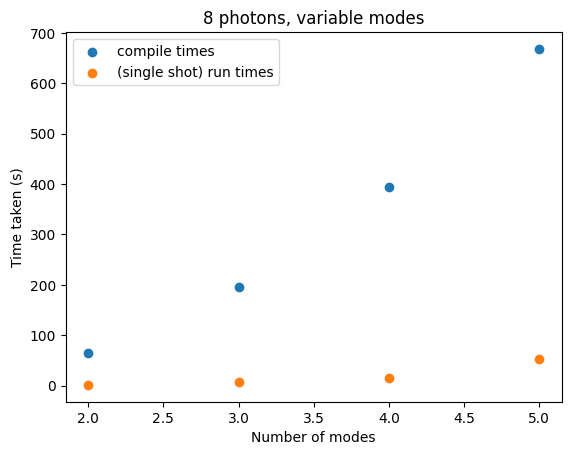

In [13]:
compile_times = [t[0][0] for t in calc_times]
run_times = [t[0][1] for t in calc_times]

plt.title("8 photons, variable modes")
plt.scatter(modes, compile_times, label=f"compile times")
plt.scatter(modes, run_times, label=f"(single shot) run times")
plt.legend()
plt.xlabel("Number of modes")
plt.ylabel("Time taken (s)")
# plt.yscale("log")
plt.show()

# Compilation vs runtime for photon number

In [5]:
modes = [2]
photons = [1,2,4,8]
calc_times = [[] for m in modes]

for idx, m in enumerate(modes):
    print(f"Running m = {m}")
    for n in photons:
        print(f"    Running n = {n}")
        U = random_unitary(m)
        photon_config = make_photon_config(num_photons=n, num_modes=m)
        compile_time, run_time = timed_interferom_simulation(U, photon_config)
        calc_times[idx].append((compile_time, run_time))

print("\n",calc_times)

Running m = 2
    Running n = 1
         Compile time:  0.028992652893066406 s
         Run time:  0.005690813064575195 s
    Running n = 2
         Compile time:  0.18620729446411133 s
         Run time:  0.006362199783325195 s
    Running n = 4
         Compile time:  2.91546630859375 s
         Run time:  0.06716060638427734 s
    Running n = 8
         Compile time:  62.78402376174927 s
         Run time:  1.9900901317596436 s

 [[(0.028992652893066406, 0.005690813064575195), (0.18620729446411133, 0.006362199783325195), (2.91546630859375, 0.06716060638427734), (62.78402376174927, 1.9900901317596436)]]


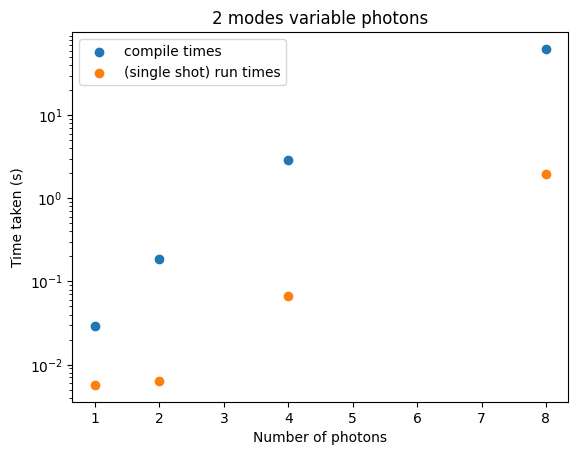

In [8]:
# for idx, m in enumerate(modes):
#     compile_times = [t[0] for t in calc_times[idx]]
#     run_times = [t[1] for t in calc_times[idx]]
#     plt.scatter(photons, compile_times, label= f"compile time -- num_modes = {m}")
#     plt.scatter(photons, run_times, label= f"run time -- num_modes = {m}")
#     plt.legend()

# plt.yscale("log")

compile_times = [t[0] for t in calc_times[0]]
run_times = [t[1] for t in calc_times[0]]
plt.scatter(photons, compile_times, label=f"compile times")
plt.scatter(photons, run_times, label=f"(single shot) run times")
plt.title("2 modes variable photons")
plt.legend()
plt.xlabel("Number of photons")
plt.ylabel("Time taken (s)")
plt.yscale("log")
plt.show()

In [6]:
modes = [8]
photons = [1,2,4]
calc_times = [[] for m in modes]

for idx, m in enumerate(modes):
    print(f"Running m = {m}")
    for n in photons:
        print(f"    Running n = {n}")
        U = random_unitary(m)
        photon_config = make_photon_config(num_photons=n, num_modes=m)
        compile_time, run_time = timed_interferom_simulation(U, photon_config)
        calc_times[idx].append((compile_time, run_time))

print("\n",calc_times)

Running m = 8
    Running n = 1
         Compile time:  0.31786584854125977 s
         Run time:  0.10421466827392578 s
    Running n = 2
         Compile time:  8.32170033454895 s
         Run time:  0.31954169273376465 s
    Running n = 4
         Compile time:  86.2484483718872 s
         Run time:  129.3915524482727 s

 [[(0.31786584854125977, 0.10421466827392578), (8.32170033454895, 0.31954169273376465), (86.2484483718872, 129.3915524482727)]]


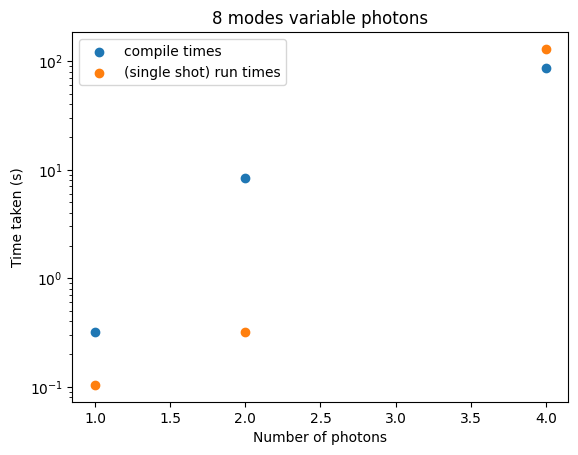

In [8]:
# for idx, m in enumerate(modes):
#     compile_times = [t[0] for t in calc_times[idx]]
#     run_times = [t[1] for t in calc_times[idx]]
#     plt.scatter(photons, compile_times, label= f"compile time -- num_modes = {m}")
#     plt.scatter(photons, run_times, label= f"run time -- num_modes = {m}")
#     plt.legend()

# plt.yscale("log")

compile_times = [t[0] for t in calc_times[0]]
run_times = [t[1] for t in calc_times[0]]
plt.scatter(photons, compile_times, label=f"compile times")
plt.scatter(photons, run_times, label=f"(single shot) run times")
plt.title("8 modes variable photons")
plt.legend()
plt.xlabel("Number of photons")
plt.ylabel("Time taken (s)")
plt.yscale("log")
plt.show()